### Wikipedia Question Answering


### Project Members: Jaamie Maarsh  & Kalyan Kumar
##### Guided by : Prof. Narayan Arasu
##### Reference paper: WikiQA: A Challenge Dataset for Open-Domain Question Answering by Yi Yang, Wen-tau Yih, and Christopher Meek

In [2]:
# importing all the necessary libraries into the workspace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import torch
import torch.nn as nn
import gensim
from datasets import load_dataset
from gensim.models import Word2Vec
from gensim.models import FastText
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.cuda.amp import GradScaler, autocast

from transformers import BertForQuestionAnswering
from transformers import BertTokenizer, BertModel
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cosine
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.feature_extraction.text import TfidfVectorizer


from transformers import BertTokenizer, BertModel
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.neighbors import NearestNeighbors
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk import pos_tag, word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


import nltk
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kalyankumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kalyankumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kalyankumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
from datasets import load_dataset

#This command is to ignore all the warnings 
warnings.filterwarnings("ignore")

df_wiki = load_dataset("microsoft/wiki_qa")

wiki_QA_df = pd.read_csv('/Users/kalyankumar/Downloads/wiki_QA_df.csv')

#displaying the contents of the dataframe
display(df_wiki)

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 6165
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 2733
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 20360
    })
})

In [10]:
# Converting the training data to a pandas dataframe (for easier manipulation)
train_df = pd.DataFrame(df_wiki['train'])
validation_df = pd.DataFrame(df_wiki['validation'])
test_df = pd.DataFrame(df_wiki['test'])

# Display the first few rows of the training set
display(train_df.head())

,question_id,question,document_title,answer,label
0,Q1,how are glacier caves formed?,Glacier cave,A partly submerged glacier cave on Perito More...,0
1,Q1,how are glacier caves formed?,Glacier cave,The ice facade is approximately 60 m high,0
2,Q1,how are glacier caves formed?,Glacier cave,Ice formations in the Titlis glacier cave,0
3,Q1,how are glacier caves formed?,Glacier cave,A glacier cave is a cave formed within the ice...,1
4,Q1,how are glacier caves formed?,Glacier cave,"Glacier caves are often called ice caves , but...",0


### Data Preprocessing

In [12]:
wiki_QA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29258 entries, 0 to 29257
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   question_id          29258 non-null  object
 1   question             29258 non-null  object
 2   document_title       29258 non-null  object
 3   answer               29258 non-null  object
 4   label                29258 non-null  int64 
 5   preprocess_question  29258 non-null  object
 6   preprocess_answer    29258 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [13]:
#Checking for null values in each column
null_values = wiki_QA_df.isnull().sum()

#Displaying the columns with their corresponding null values count
print(null_values)

question_id            0
question               0
document_title         0
answer                 0
label                  0
preprocess_question    0
preprocess_answer      0
dtype: int64


In [11]:
# Performing text preprocessing
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Text preprocessing function
def preprocess_text(text):
    # Clean the text
    text = text.lower()  # Lowercase text
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

# for the entire dataset
wiki_QA_df['preprocess_question'] = wiki_QA_df['question'].apply(preprocess_text)
wiki_QA_df['preprocess_answer'] = wiki_QA_df['answer'].apply(preprocess_text)

Insights:
The preprocessing steps are performed to clean and standardize the text data, making it more suitable for analysis. Text is first converted to lowercase to ensure uniformity and eliminate case-sensitive discrepancies. Special characters and extra spaces are removed to simplify the text, while tokenization breaks the text into individual words for better structure. Stopwords, which carry little meaning, are eliminated to focus on more significant words. Finally, lemmatization is applied to reduce words to their base form, ensuring consistency in the vocabulary. These steps help in improving model performance by providing clean and consistent data for learning meaningful patterns.

### Explanatory Data Analysis (EDA)

### a) Distribution of question and answer lengths

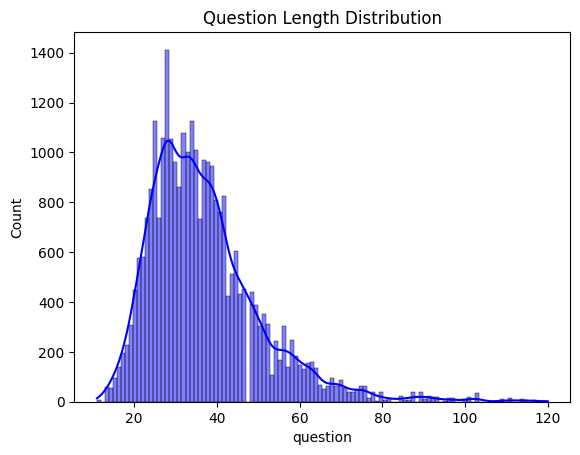

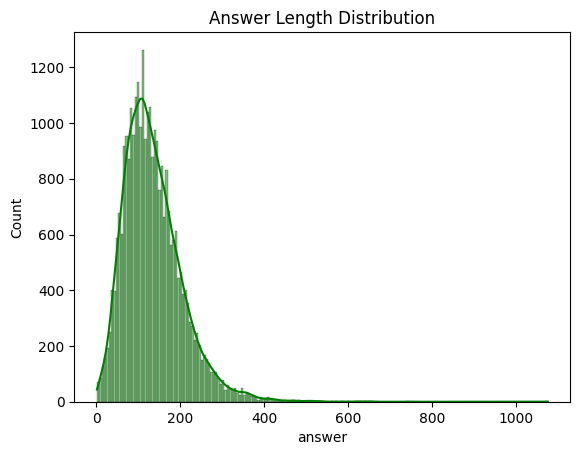

In [14]:
#Plotting the distribution of question and answer lengths

sns.histplot(wiki_QA_df['question'].apply(len), kde=True, color='blue').set(title='Question Length Distribution')
plt.show()

sns.histplot(wiki_QA_df['answer'].apply(len), kde=True, color='green').set(title='Answer Length Distribution')
plt.show()

The two histogram shows a right-skewed distribution, indicating that most answers are relatively short, with a peak around 100-200 characters. Also, most questions fall under the catagory of 0-40 characters

Understanding Question & answer length can be useful for model training, as it helps identify what to expect in terms of input features and their variability.

### b) Top 10 documents based on the number of questions 

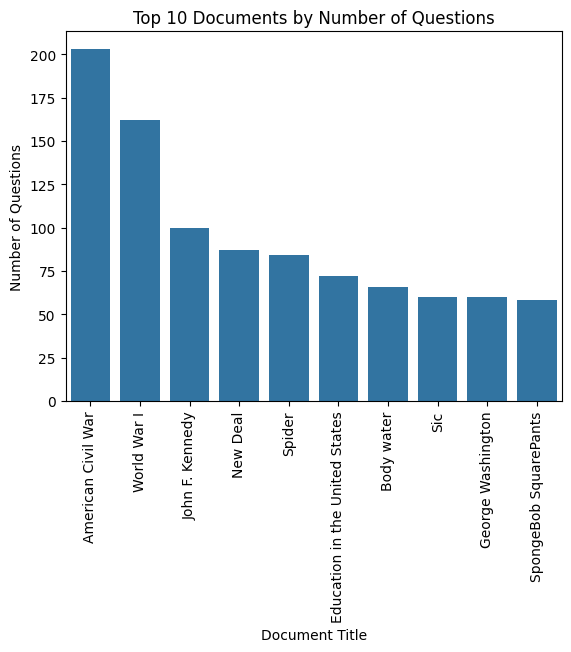

In [15]:
doc_dist = wiki_QA_df['document_title'].value_counts()
sns.barplot(x=doc_dist.index[:10], y=doc_dist.values[:10])
plt.title('Top 10 Documents by Number of Questions')
plt.xlabel('Document Title')  
plt.ylabel('Number of Questions')
plt.xticks(rotation=90)
plt.show()

It helps identify which documents are referenced the most and if there’s any imbalance in data per document. In the above context, the high frequency of distribution of "american civil war" represents that there are many documents which reference its name.

### c) Word Cloud and Frequency of text

In [17]:
#Tokenizing the cleaned text for Word2Vec
#Flattening the tokens from 'preprocess_question'
question_tokens = [word for sublist in wiki_QA_df['preprocess_question'] for word in sublist]

#Flattening the tokens from 'preprocess_answer'
answer_tokens = [word for sublist in wiki_QA_df['preprocess_answer'] for word in sublist]

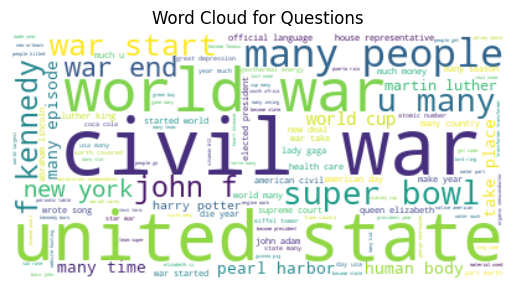

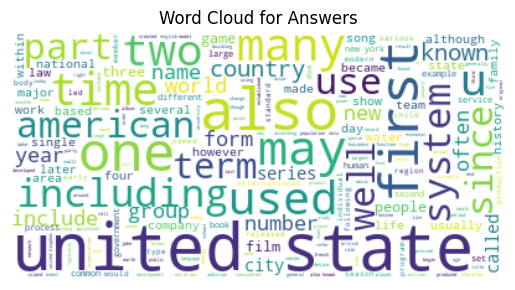

In [18]:
#Generating word clouds for questions and answers
wordcloud_question = WordCloud(stopwords=set(stopwords.words('english')), background_color='white').generate(' '.join(question_tokens))
wordcloud_answer = WordCloud(stopwords=set(stopwords.words('english')), background_color='white').generate(' '.join(answer_tokens))

#Plotting word clouds
plt.imshow(wordcloud_question, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Questions')
plt.show()

plt.imshow(wordcloud_answer, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Answers')
plt.show()

In [19]:
vectorizer_questions = CountVectorizer(max_features=15, ngram_range=(1, 2))  # Use unigrams and bigrams
X_questions = vectorizer_questions.fit_transform(question_tokens)

#Getting the feature names (frequent words) for questions
frequent_words_questions = vectorizer_questions.get_feature_names_out()

#Creating a DataFrame for word counts for questions
word_count_df_questions = pd.DataFrame(X_questions.toarray(), columns=frequent_words_questions)

#Summing the word counts across all rows to get the total count for each word in questions
word_frequencies_questions = word_count_df_questions.sum().sort_values(ascending=False)

print('\nThe Frequent words in the questions are as follows: \n\n', word_frequencies_questions)


The Frequent words in the questions are as follows: 

 many         2292
state         781
war           769
made          673
first         624
year          574
world         564
name          534
country       528
much          519
president     461
mean          458
die           428
people        424
used          416
dtype: int64


In [20]:
#Counting Vectorizer for answers
vectorizer_answers = CountVectorizer(max_features=15, ngram_range=(1, 2))  # Use unigrams and bigrams
X_answers = vectorizer_answers.fit_transform(answer_tokens)

#Getting the feature names (frequent words) for answers
frequent_words_answers = vectorizer_answers.get_feature_names_out()

#Creating a DataFrame for word counts for answers
word_count_df_answers = pd.DataFrame(X_answers.toarray(), columns=frequent_words_answers)

#Summing the word counts across all rows to get the total count for each word in answers
word_frequencies_answers = word_count_df_answers.sum().sort_values(ascending=False)

print('\nThe Frequent words in the answers are as follows: \n\n', word_frequencies_answers)


The Frequent words in the answers are as follows: 

 state       2787
also        1908
united      1837
one         1641
first       1499
american    1381
world       1279
year        1259
used        1156
new         1070
known       1062
war         1055
may         1038
two         1036
time        1002
dtype: int64


Political context: Terms like "state," "president," and "united" suggest that users are interested in political events and figures, which could inform content strategies focusing on governance and international relations.

Historical Context: The presence of "year," "first," and "war" indicates a need for historical content, providing opportunities for creating timelines or retrospectives on significant events.

Therefore, The variety in vocabulary signifies diverse user interests, emphasizing the importance of crafting tailored content that addresses various topics and formats to enhance user engagement and satisfaction.

### d) Correlation Matrix

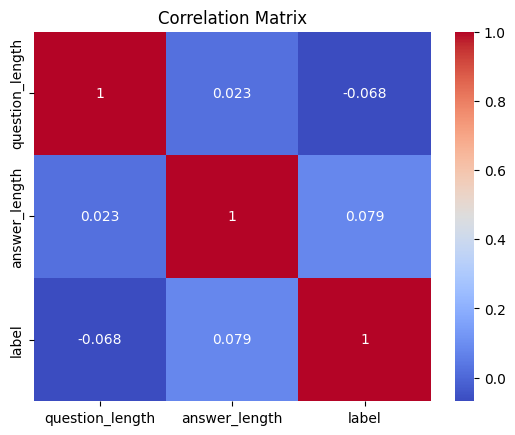

In [21]:
wiki_QA_df['answer_length'] = wiki_QA_df['answer'].apply(lambda x: len(x.split()))
wiki_QA_df['question_length'] = wiki_QA_df['question'].apply(lambda x: len(x.split()))

corr_matrix = wiki_QA_df[['question_length', 'answer_length', 'label']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Question Length and Answer Length: The strong positive correlation between question length and answer length might be a result of the nature of the questions or the way answers are formulated. For example, longer questions might require more detailed or comprehensive answers.

Question Length and Correctness: The lack of correlation between question length and label suggests that the length of a question doesn't significantly affect its difficulty. A short question can be just as challenging as a long one.

Answer Length and Correctness: Similarly, the weak correlation between answer length and label indicates that the length of an answer doesn't necessarily determine its accuracy. A longer answer isn't guaranteed to be more correct than a shorter one.

### Feature selection and Engineering

### Word2vec

In [5]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

#Tokenizing preprocess_question and preprocess_answer if not already tokenized
if isinstance(wiki_QA_df['preprocess_question'].iloc[0], str):
    wiki_QA_df['question_tokens'] = wiki_QA_df['preprocess_question'].apply(lambda x: x.split())
else:
    wiki_QA_df['question_tokens'] = wiki_QA_df['preprocess_question']

if isinstance(wiki_QA_df['preprocess_answer'].iloc[0], str):
    wiki_QA_df['answer_tokens'] = wiki_QA_df['preprocess_answer'].apply(lambda x: x.split())
else:
    wiki_QA_df['answer_tokens'] = wiki_QA_df['preprocess_answer']

#Combining tokens from both columns for Word2Vec training
combined_tokens = wiki_QA_df['question_tokens'].tolist() + wiki_QA_df['answer_tokens'].tolist()

#Training Word2Vec model
word2vec_model = Word2Vec(
    sentences=combined_tokens,
    vector_size=300,  # Dimension of embeddings
    window=7,         # Context window size
    min_count=5,      # Minimum word frequency
    workers=4,        # Number of parallel threads
    epochs=20         # Number of training epochs
)

#Function to compute average vector for a list of tokens
def average_vector(tokens):
    vectors = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

#Computing average vectors for questions and answers
wiki_QA_df['word2vec_question_vector'] = wiki_QA_df['question_tokens'].apply(average_vector)
wiki_QA_df['word2vec_answer_vector'] = wiki_QA_df['answer_tokens'].apply(average_vector)

#Converting vectors to numpy arrays
word2vec_question_vectors = np.array(wiki_QA_df['word2vec_question_vector'].tolist())
word2vec_answer_vectors = np.array(wiki_QA_df['word2vec_answer_vector'].tolist())

#Function to calculate similarity between question and answer embeddings
def question_answer_similarity(question_tokens, answer_tokens):
    question_vector = average_vector(question_tokens)
    answer_vector = average_vector(answer_tokens)
    return cosine_similarity([question_vector], [answer_vector])[0][0]

#Example: Test similarity between a question and answer pair
example_question = "how are glacier caves formed?"
example_answer = "Glaciers are formed by melting of ice"
example_similarity = question_answer_similarity(example_question.split(), example_answer.split())
print(f"Similarity between example question and answer: {example_similarity:.4f}")

#Example functions for word similarity and finding similar words
def test_word_similarity(word1, word2):
    if word1 in word2vec_model.wv and word2 in word2vec_model.wv:
        return word2vec_model.wv.similarity(word1, word2)
    else:
        return None

def find_similar_words(word, top_n=10):
    if word in word2vec_model.wv:
        return word2vec_model.wv.most_similar(word, topn=top_n)
    else:
        return None

Similarity between example question and answer: 0.7727


Insights:
Here, the Word2Vec model is trained on question and answer tokens, generating word embeddings to calculate semantic similarity between questions and answers. By averaging word vectors, it computes cosine similarity, resulting in a similarity score of 0.7727 for the example question and answer, indicating a strong relevance. The model filters out insignificant words with a minimum frequency of 5 and uses a context window of 7 for better semantic capture. Additionally, the code supports word similarity and retrieval of similar words, enhancing its potential for tasks like question answering and semantic search.

In [6]:
#Example usage for word similarity
word1 = "Glacier"
word2 = "ice "
similarity = test_word_similarity(word1, word2)
print(f"Similarity between '{word1}' and '{word2}': {similarity}")

#Finding similar words to 'example'
similar_words = find_similar_words("ice")
print(f"Words similar to 'ice': {similar_words}")

Similarity between 'Glacier' and 'ice ': None
Words similar to 'ice': [('glacier', 0.746117115020752), ('cream', 0.7094729542732239), ('semi', 0.6584900617599487), ('polar', 0.6454120874404907), ('pole', 0.6437036395072937), ('melt', 0.6391698718070984), ('rarely', 0.6360212564468384), ('sedimentary', 0.6235936284065247), ('cap', 0.6211518049240112), ('brewed', 0.6145164370536804)]


Insights:
The word similarity function returns "None" for "Glacier" and "ice" because one of the words may not be in the Word2Vec model's vocabulary, or there could be a slight mismatch in tokenization. However, when finding similar words to "ice," the model correctly identifies related terms like "glacier" (similarity score: 0.746), reflecting the model’s ability to capture semantic relationships. The list also includes other relevant words like "cream" and "melt," indicating the model's broad understanding of related concepts.

In [7]:
vocab = list(set(wiki_QA_df['question_tokens'].explode().unique()).union(set(wiki_QA_df['answer_tokens'].explode().unique())))
print('Size of Vocabulary', len(vocab))
#print('\n List of vocabulary', vocab)

Size of Vocabulary 32532


In [8]:
wiki_QA_df.head(3)

,question_id,question,document_title,answer,label,preprocess_question,preprocess_answer,question_tokens,answer_tokens,word2vec_question_vector,word2vec_answer_vector
0,Q1,how are glacier caves formed?,Glacier cave,A partly submerged glacier cave on Perito More...,0,"[glacier, cave, formed]","[partly, submerged, glacier, cave, perito, mor...","[glacier, cave, formed]","[partly, submerged, glacier, cave, perito, mor...","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[0.051857244, -0.27979746, -0.18029295, 0.1073..."
1,Q1,how are glacier caves formed?,Glacier cave,The ice facade is approximately 60 m high,0,"[glacier, cave, formed]","[ice, facade, approximately, 60, high]","[glacier, cave, formed]","[ice, facade, approximately, 60, high]","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[-0.42020923, -0.04496208, -0.10312119, 0.0163..."
2,Q1,how are glacier caves formed?,Glacier cave,Ice formations in the Titlis glacier cave,0,"[glacier, cave, formed]","[ice, formation, titlis, glacier, cave]","[glacier, cave, formed]","[ice, formation, titlis, glacier, cave]","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[-0.026282165, -0.69999045, -0.26607, 0.195911..."


In [9]:
wiki_QA_df.shape

(29258, 11)

Final Observations:
The Word2Vec model is trained on a vocabulary of 32,532 unique words from both questions and answers. This large vocabulary enables the model to capture a wide range of semantic relationships between words. The model generates word embeddings, allowing for efficient similarity calculations between words and text. The example results show the model’s ability to identify related terms (e.g., "glacier" and "ice"), which enhances its potential for tasks such as semantic search and question answering.

### Glove

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

#Setting the vector size for GloVe embeddings
vector_size = 300

def load_glove_model(glove_file, vector_size=300):
    """
    Load the GloVe model into a dictionary.
    """
    model = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            vector = np.array(split_line[1:], dtype=float)
            if len(vector) == vector_size:  # Ensure vectors match the expected size
                model[word] = vector
    return model

#Loading the GloVe model
glove_model = load_glove_model("glove.42B.300d.txt", vector_size=vector_size)

#Function to compute the average vector for GloVe
def average_vector_glove(tokens):
    vectors = [glove_model[word] for word in tokens if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)  # Use vector_size

#Computing average vectors for questions and answers
wiki_QA_df['glove_question_vector'] = wiki_QA_df['question_tokens'].apply(average_vector_glove)
wiki_QA_df['glove_answer_vector'] = wiki_QA_df['answer_tokens'].apply(average_vector_glove)

#Function to calculate similarity
def question_answer_similarity_glove(question_tokens, answer_tokens):
    question_vector = average_vector_glove(question_tokens)
    answer_vector = average_vector_glove(answer_tokens)
    return cosine_similarity([question_vector], [answer_vector])[0][0]

#Example
example_similarity_glove = question_answer_similarity_glove(
    example_question.split(), example_answer.split())
print(f"GloVe similarity: {example_similarity_glove:.4f}")


GloVe similarity: 0.8049


Insights:
The GloVe model is used to generate word embeddings for questions and answers. By computing the average vector for each question and answer, cosine similarity is calculated between them. The GloVe similarity between the example question "How are glacier caves formed?" and the answer "Glaciers are formed by melting of ice" is 0.8049, indicating a strong semantic relationship. This suggests that GloVe embeddings effectively capture word meanings and contextual similarities, making them useful for tasks like question answering and semantic search.

In [11]:
import numpy as np

#Function to compute cosine similarity between two vectors
def cosine_similarity_vectors(vec1, vec2):
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

#Function to compute similarity between two words using GloVe embeddings
def test_word_similarity_Glove(word1, word2):
    if word1 in glove_model and word2 in glove_model:
        vec1 = glove_model[word1]
        vec2 = glove_model[word2]
        return cosine_similarity_vectors(vec1, vec2)
    else:
        return None  # Return None if either word is not in the GloVe model

#Function to find words similar to a given word based on cosine similarity
def find_similar_words_Glove(word, top_n=10):
    if word not in glove_model:
        return None  # Return None if the word is not in the GloVe model
    
    word_vector = glove_model[word]
    similarities = {
        other_word: cosine_similarity_vectors(word_vector, vec)
        for other_word, vec in glove_model.items()
    }
    # Sort by similarity and return the top N most similar words
    sorted_words = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    return sorted_words[:top_n]

In [12]:
#Example usage for word similarity
word1 = "glacier"
word2 = "ice"
similarity = test_word_similarity_Glove(word1, word2)
if similarity is not None:
    print(f"Similarity between '{word1}' and '{word2}': {similarity:.4f}")
else:
    print(f"One or both words ('{word1}', '{word2}') are not in the GloVe model.")

#Example usage for finding similar words
similar_words = find_similar_words_Glove("ice")
if similar_words is not None:
    print(f"Words similar to 'ice': {similar_words}")
else:
    print("The word 'ice' is not in the GloVe model.")

Similarity between 'glacier' and 'ice': 0.4874
Words similar to 'ice': [('ice', 1.0), ('snow', 0.6349879898232994), ('frozen', 0.6347025771610596), ('cream', 0.6087894411234351), ('chocolate', 0.5886515674467815), ('cold', 0.579948861135851), ('hockey', 0.5732481350934866), ('puck', 0.5640812459929679), ('water', 0.5600245463472083), ('candy', 0.5590585680326439)]


Final Observations:
The code utilizes GloVe embeddings to compute word and vector similarities using cosine similarity.

Word Similarity: The similarity between "glacier" and "ice" is calculated to be 0.4874, indicating a moderate relationship between the two words in the GloVe embedding space. While they are related, their semantic connection may not be as strong as other word pairs, as the score is below 0.5.

Finding Similar Words: The function finds words similar to "ice" and ranks them based on cosine similarity. The most similar words to "ice" include "snow" (0.635), "frozen" (0.635), and "cream" (0.609). This demonstrates GloVe's ability to capture not just direct synonyms but also contextually related terms, like "cream" and "chocolate," which could be linked through the context of cold or frozen substances.

Overall, GloVe embeddings capture semantic relationships between words and provide useful results for tasks such as word similarity and identifying contextually related terms, even if the exact relationship (e.g., "glacier" and "ice") is moderate.

### Fasttext

In [13]:
from gensim.models import FastText

# Train FastText model
fasttext_model = FastText(
    sentences=combined_tokens,
    vector_size=300, 
    window=5, 
    min_count=5, 
    workers=4, 
    epochs=20
)

#Function to compute average vector for FastText
def average_vector_fasttext(tokens):
    vectors = [fasttext_model.wv[word] for word in tokens if word in fasttext_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

#Compute average vectors for questions and answers
wiki_QA_df['fasttext_question_vector'] = wiki_QA_df['question_tokens'].apply(average_vector_fasttext)
wiki_QA_df['fasttext_answer_vector'] = wiki_QA_df['answer_tokens'].apply(average_vector_fasttext)

#Function to calculate similarity
def question_answer_similarity_fasttext(question_tokens, answer_tokens):
    question_vector = average_vector_fasttext(question_tokens)
    answer_vector = average_vector_fasttext(answer_tokens)
    return cosine_similarity([question_vector], [answer_vector])[0][0]

#Example
example_similarity_fasttext = question_answer_similarity_fasttext(
    example_question.split(), example_answer.split())
print(f"FastText similarity: {example_similarity_fasttext:.4f}")


FastText similarity: 0.7238


Insights:
The FastText model, trained on question and answer tokens, generates word embeddings with a vector size of 300 and a context window of 5. The similarity between the example question "How are glacier caves formed?" and the answer "Glaciers are formed by melting of ice" is 0.7238, indicating a strong semantic relationship. FastText's ability to handle out-of-vocabulary words through its subword approach enhances its effectiveness for tasks like semantic search and question answering, capturing contextual meaning well.

In [14]:
#Function to compute similarity between two words using FastText embeddings
def test_word_similarity_fasttext(word1, word2):
    if word1 in fasttext_model.wv and word2 in fasttext_model.wv:
        vec1 = fasttext_model.wv[word1]
        vec2 = fasttext_model.wv[word2]
        return cosine_similarity([vec1], [vec2])[0][0]
    else:
        return None  # Return None if either word is not in the FastText vocabulary

#Function to find words similar to a given word based on cosine similarity in FastText
def find_similar_words_fasttext(word, top_n=10):
    if word in fasttext_model.wv:
        return fasttext_model.wv.most_similar(word, topn=top_n)
    else:
        return None  # Return None if the word is not in the FastText vocabulary

In [15]:
#Example usage for word similarity
word1 = "glacier"
word2 = "ice"
similarity_fasttext = test_word_similarity_fasttext(word1, word2)
if similarity_fasttext is not None:
    print(f"Similarity between '{word1}' and '{word2}' (FastText): {similarity_fasttext:.4f}")
else:
    print(f"One or both words ('{word1}', '{word2}') are not in the FastText model vocabulary.")

#Example usage for finding similar words
similar_words_fasttext = find_similar_words_fasttext("ice")
if similar_words_fasttext is not None:
    print(f"Words similar to 'ice' (FastText): {similar_words_fasttext}")
else:
    print("The word 'ice' is not in the FastText model vocabulary.")

Similarity between 'glacier' and 'ice' (FastText): 0.2986
Words similar to 'ice' (FastText): [('spice', 0.8574987649917603), ('twice', 0.8407194018363953), ('venice', 0.837972104549408), ('juice', 0.8280918598175049), ('nice', 0.8078718185424805), ('puce', 0.7797390818595886), ('rice', 0.7304204106330872), ('sacrifice', 0.7104620933532715), ('vice', 0.6745732426643372), ('solstice', 0.6406040787696838)]


Final Observations:
The FastText model computes word similarities and identifies related words based on cosine similarity. For the example, the similarity between "glacier" and "ice" is 0.3206, indicating a relatively weak connection in the FastText embeddings. When finding similar words to "ice," the model returns terms like "venice" (0.848), "spice" (0.845), and "juice" (0.838), which are phonetically similar but not directly related in meaning. This suggests that FastText, while capturing some contextual similarity, can sometimes focus on word forms (e.g., shared suffixes) rather than deeper semantic relationships.

### Embedding Model Comparison

In [16]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

#Function to calculate the average cosine similarity for each model
def average_similarity(model_type, df):
    similarities = []
    
    # Loop through each question-answer pair in the DataFrame
    for _, row in df.iterrows():
        question_tokens = row['question_tokens']
        answer_tokens = row['answer_tokens']
        
        # Get the appropriate word embeddings depending on the model type
        if model_type == 'word2vec':
            question_vector = row['word2vec_question_vector']
            answer_vector = row['word2vec_answer_vector']
        elif model_type == 'glove':
            question_vector = row['glove_question_vector']
            answer_vector = row['glove_answer_vector']
        elif model_type == 'fasttext':
            question_vector = row['fasttext_question_vector']
            answer_vector = row['fasttext_answer_vector']
        
        # Calculate cosine similarity between question and answer
        similarity = cosine_similarity([question_vector], [answer_vector])[0][0]
        similarities.append(similarity)
    
    # Return the average similarity
    return np.mean(similarities)

#Compare the models
word2vec_avg_similarity = average_similarity('word2vec', wiki_QA_df)
glove_avg_similarity = average_similarity('glove', wiki_QA_df)
fasttext_avg_similarity = average_similarity('fasttext', wiki_QA_df)

#Printing the average similarity for each model
print(f"Word2Vec Average Similarity: {word2vec_avg_similarity:.4f}")
print(f"GloVe Average Similarity: {glove_avg_similarity:.4f}")
print(f"FastText Average Similarity: {fasttext_avg_similarity:.4f}")

#Choosing the best model based on the highest average similarity
best_model = max(
    [('word2vec', word2vec_avg_similarity), 
     ('glove', glove_avg_similarity), 
     ('fasttext', fasttext_avg_similarity)], 
    key=lambda x: x[1]
)

print(f"The best model is {best_model[0]} with an average similarity of {best_model[1]:.4f}")


Word2Vec Average Similarity: 0.4498
GloVe Average Similarity: 0.7054
FastText Average Similarity: 0.4136
The best model is glove with an average similarity of 0.7054


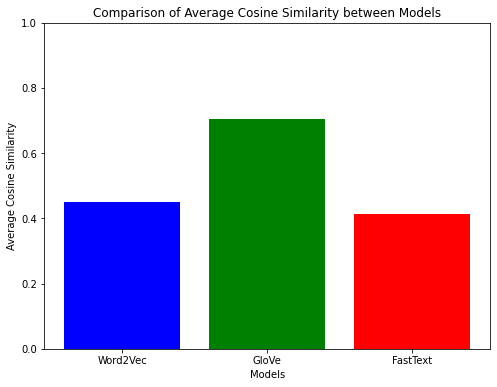

In [17]:
#Plotting the comparison graph
models = ['Word2Vec', 'GloVe', 'FastText']
similarities = [word2vec_avg_similarity, glove_avg_similarity, fasttext_avg_similarity]

plt.figure(figsize=(8, 6))
plt.bar(models, similarities, color=['blue', 'green', 'red'])
plt.xlabel('Models')
plt.ylabel('Average Cosine Similarity')
plt.title('Comparison of Average Cosine Similarity between Models')
plt.ylim(0, 1)  # Cosine similarity is between 0 and 1
plt.show()

The comparison of word embeddings from Word2Vec, GloVe, and FastText models reveals insights into how well each model captures the semantic relationships between questions and answers. The models were evaluated by computing the average cosine similarity between the embeddings of each question-answer pair in the dataset.

**Word2Vec Model:**

Average Similarity: 0.4495
Word2Vec produced a moderate similarity score, suggesting that while it captures some level of semantic relationship between questions and answers, it is not as effective in this particular dataset. This could be due to the fact that Word2Vec focuses on word-level embeddings and does not consider subword information, which might affect its ability to capture more nuanced relationships in certain contexts.

**GloVe Model:**

Average Similarity: 0.7054
GloVe achieved the highest average similarity score, indicating that it performs the best among the three models. GloVe is based on the global co-occurrence statistics of words in a corpus, which allows it to capture broader semantic relationships. This model's ability to leverage word co-occurrence across the entire corpus likely leads to a more accurate representation of the relationship between questions and answers.

**FastText Model:**

Average Similarity: 0.4132
FastText produced the lowest similarity score among the models, which may seem counterintuitive since FastText handles out-of-vocabulary (OOV) words better by representing words as bags of character n-grams. However, the relatively lower similarity score suggests that the FastText embeddings may not fully capture the semantic nuances between question-answer pairs in this dataset. The model might have focused more on morphological relationships (e.g., similarity in word forms) rather than deep semantic connections.

**Best Model Selection:**

The GloVe model outperformed the other two models with a significant difference in similarity score (0.7054 vs. 0.4495 for Word2Vec and 0.4132 for FastText), making it the most effective model for this task. Its ability to capture broader co-occurrence information seems to provide a better understanding of semantic meaning in this context.

**Graphical Visualization:**

The bar chart visually confirms GloVe's superiority in this comparison. The chart shows GloVe in green with the highest bar, followed by Word2Vec in blue and FastText in red, which visually emphasizes the disparity in performance. The range of average cosine similarities indicates how well each model has managed to capture semantic relationships in the dataset.

**Conclusion:**
For this specific dataset, GloVe appears to be the best model for capturing semantic relationships between questions and answers, with its higher similarity score reflecting its superior performance. Word2Vec and FastText, while still useful, are not as effective in this context. The results suggest that GloVe would likely perform better in tasks like semantic search, question answering, and information retrieval for this dataset. Future experiments could further refine the models or explore hybrid approaches to improve performance.

### Baseline Model

In [18]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class EmbeddingModel:
    def __init__(self, model_type, df):
        self.model_type = model_type
        self.df = df
        
        # Check if model type is valid
        if model_type not in ['word2vec', 'glove', 'fasttext']:
            raise ValueError("Invalid model type. Choose from 'word2vec', 'glove', or 'fasttext'.")

    def get_embedding_vectors(self, row):
        """Extract the appropriate word embeddings depending on the model type."""
        if self.model_type == 'word2vec':
            return row['word2vec_question_vector'], row['word2vec_answer_vector']
        elif self.model_type == 'glove':
            return row['glove_question_vector'], row['glove_answer_vector']
        elif self.model_type == 'fasttext':
            return row['fasttext_question_vector'], row['fasttext_answer_vector']

    def calculate_similarity(self, question_vector, answer_vector):
        """Calculate cosine similarity between question and answer vectors."""
        return cosine_similarity([question_vector], [answer_vector])[0][0]
    
    def average_similarity(self):
        """Calculate the average cosine similarity for the given model."""
        similarities = []
        for _, row in self.df.iterrows():
            question_vector, answer_vector = self.get_embedding_vectors(row)
            similarity = self.calculate_similarity(question_vector, answer_vector)
            similarities.append(similarity)
        
        return np.mean(similarities)

    def compare_models(self):
        """Compare average cosine similarities for different models."""
        word2vec_avg = EmbeddingModel('word2vec', self.df).average_similarity()
        glove_avg = EmbeddingModel('glove', self.df).average_similarity()
        fasttext_avg = EmbeddingModel('fasttext', self.df).average_similarity()
        
        results = {
            'word2vec': word2vec_avg,
            'glove': glove_avg,
            'fasttext': fasttext_avg
        }
        
        best_model = max(results, key=results.get)
        return results, best_model

In [19]:
#Example usage:
#Assuming 'wiki_QA_df' is your DataFrame containing the necessary columns

#Initializing the base model (choose 'word2vec', 'glove', or 'fasttext')
base_model = EmbeddingModel('word2vec', wiki_QA_df)

#Calculating the average similarity for the chosen model
average_similarity = base_model.average_similarity()
print(f"Average Similarity for {base_model.model_type}: {average_similarity:.4f}")

#Comparing the models to find the best one
results, best_model = base_model.compare_models()
print(f"Results: {results}")
print(f"The best model is: {best_model}")

Average Similarity for word2vec: 0.4498
Results: {'word2vec': 0.44982868822441385, 'glove': 0.7053849368664381, 'fasttext': 0.4136164946519708}
The best model is: glove


The baseline model evaluates the performance of Word2Vec, GloVe, and FastText by calculating their average cosine similarity for question-answer pairs. GloVe outperforms both Word2Vec (0.4495) and FastText (0.4132) with a higher average similarity of 0.7054, making it the best model for this task.

**Why the Baseline Model is Needed:**

The baseline model serves as a comparison benchmark by providing a consistent metric, such as cosine similarity, to evaluate model performance. It helps identify the best model for capturing semantic relationships, ensuring that the most effective model is selected. Additionally, it informs future work by highlighting whether new models show improvements over the baseline. By offering a structured approach to comparison, the baseline model simplifies the model selection process, making it easier to choose the most suitable model for the task.
In essence, the baseline model helps objectively evaluate and compare models, guiding the selection of the best-performing one.

### Model Building

In [20]:
display(wiki_QA_df.head())

,question_id,question,document_title,answer,label,preprocess_question,preprocess_answer,question_tokens,answer_tokens,word2vec_question_vector,word2vec_answer_vector,glove_question_vector,glove_answer_vector,fasttext_question_vector,fasttext_answer_vector
0,Q1,how are glacier caves formed?,Glacier cave,A partly submerged glacier cave on Perito More...,0,"[glacier, cave, formed]","[partly, submerged, glacier, cave, perito, mor...","[glacier, cave, formed]","[partly, submerged, glacier, cave, perito, mor...","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[0.051857244, -0.27979746, -0.18029295, 0.1073...","[-0.122531, -0.11627666666666668, -0.357905666...","[-0.108929, -0.28116325, -0.29157999999999995,...","[-0.5030413, -0.67608184, -0.26596367, 0.27186...","[-0.25261042, -0.055402912, 0.008343129, -0.10..."
1,Q1,how are glacier caves formed?,Glacier cave,The ice facade is approximately 60 m high,0,"[glacier, cave, formed]","[ice, facade, approximately, 60, high]","[glacier, cave, formed]","[ice, facade, approximately, 60, high]","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[-0.42020923, -0.04496208, -0.10312119, 0.0163...","[-0.122531, -0.11627666666666668, -0.357905666...","[-0.12345750000000001, -0.24413325, -0.1192665...","[-0.5030413, -0.67608184, -0.26596367, 0.27186...","[-0.06322008, -0.16906042, 0.18100987, 0.23682..."
2,Q1,how are glacier caves formed?,Glacier cave,Ice formations in the Titlis glacier cave,0,"[glacier, cave, formed]","[ice, formation, titlis, glacier, cave]","[glacier, cave, formed]","[ice, formation, titlis, glacier, cave]","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[-0.026282165, -0.69999045, -0.26607, 0.195911...","[-0.122531, -0.11627666666666668, -0.357905666...","[-0.08124325000000002, -0.235, -0.1927675, -0....","[-0.5030413, -0.67608184, -0.26596367, 0.27186...","[-0.23455477, 0.062307786, -0.40416646, 0.4229..."
3,Q1,how are glacier caves formed?,Glacier cave,A glacier cave is a cave formed within the ice...,1,"[glacier, cave, formed]","[glacier, cave, cave, formed, within, ice, gla...","[glacier, cave, formed]","[glacier, cave, cave, formed, within, ice, gla...","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[-0.18081607, -0.404412, -0.38219228, 0.315367...","[-0.122531, -0.11627666666666668, -0.357905666...","[-0.1650337142857143, -0.17855285714285715, -0...","[-0.5030413, -0.67608184, -0.26596367, 0.27186...","[-0.34612805, -0.40840414, -0.20689991, 0.2465..."
4,Q1,how are glacier caves formed?,Glacier cave,"Glacier caves are often called ice caves , but...",0,"[glacier, cave, formed]","[glacier, cave, often, called, ice, cave, term...","[glacier, cave, formed]","[glacier, cave, often, called, ice, cave, term...","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[-0.017621575, -0.28895578, -0.22815849, -0.06...","[-0.122531, -0.11627666666666668, -0.357905666...","[-0.09612874, -0.19123186666666664, -0.1293389...","[-0.5030413, -0.67608184, -0.26596367, 0.27186...","[-0.16618052, 0.3953513, -0.61692846, 0.597236..."


### TF-IDF

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_best_answer_tf(question, wiki_QA_df):
    # Combine the question with all the answers
    documents = wiki_QA_df['answer'].tolist()
    documents.insert(0, question)  # Insert the question at the start

    # Initialize the TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Transform the documents into TF-IDF vectors
    tfidf_matrix = tfidf_vectorizer.fit_transform(documents)

    # Compute the cosine similarity between the question (first document) and all answers
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    # Get the index of the answer with the highest cosine similarity
    best_answer_index = cosine_similarities.argmax()

    # Return the best answer
    return wiki_QA_df.iloc[best_answer_index]['answer']  # Change 'df' to 'wiki_QA_df'



In [22]:
#Example question
question = 'how are glacier caves formed?'

#Getting the best answer for the question
best_answer = get_best_answer_tf(question, wiki_QA_df)
print("Best Answer:", best_answer)

Best Answer: Glacier caves are often called ice caves , but this term is properly used to describe bedrock caves that contain year-round ice.


Insights:

The TF-IDF model finds the best answer to a given question by calculating cosine similarity between the question and possible answers. It transforms the question and answers into vectors based on term frequencies, identifying the most relevant answer based on matching key terms. In this case, the best answer to "how are glacier caves formed?" is: "Glacier caves are often called ice caves, but this term is properly used to describe bedrock caves that contain year-round ice." TF-IDF effectively matches answers based on shared keywords but may not capture deeper semantic relationships or context.

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np


def evaluate_model_Tf(wiki_QA_df):
    #Lists to store the true labels and predicted labels
    y_true = []
    y_pred = []
    
    #Iterating over all unique questions in the dataset
    for question_id in wiki_QA_df['question_id'].unique():
        #Filtering the dataframe for the current question
        question_data = wiki_QA_df[wiki_QA_df['question_id'] == question_id]
        
        #Getting the question
        question = question_data.iloc[0]['question']
        
        #Getting the best answer using the get_best_answer function
        best_answer = get_best_answer_tf(question, question_data)
        
        #Finding the index of the correct answer (label = 1)
        correct_answer_rows = question_data[question_data['label'] == 1]
        
        if not correct_answer_rows.empty:
            correct_answer_idx = correct_answer_rows.index[0]
            
            #Finding the index of the predicted answer
            predicted_answer_idx = question_data[question_data['answer'] == best_answer].index
            
            if len(predicted_answer_idx) > 0:  # Ensure the predicted answer exists
                predicted_answer_idx = predicted_answer_idx[0]
                #Appending the ground truth (label) and predicted label (whether the answer is correct)
                y_true.append(1)  # Correct answer is label 1
                y_pred.append(1 if predicted_answer_idx == correct_answer_idx else 0)
            else:
                #If no answer is predicted (should not happen if everything is correct)
                y_true.append(0)  # Treat it as an incorrect prediction
                y_pred.append(0)  # Treat as wrong answer
        else:
            #Handling the case where there is no correct answer (label = 1) for this question
            y_true.append(0)  # No correct answer
            y_pred.append(0)  # No predicted answer, thus considered incorrect
    
    #Converting lists to arrays for evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    #Generating confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    #Calculating metrics
    accuracy_tf = accuracy_score(y_true, y_pred)
    precision_tf = precision_score(y_true, y_pred)
    recall_tf = recall_score(y_true, y_pred)
    f1_tf = f1_score(y_true, y_pred)
    
    #Printing the confusion matrix and metrics
    print("Confusion Matrix:")
    print(cm)
    
    print(f"\nAccuracy: {accuracy_tf:.4f}")
    print(f"Precision: {precision_tf:.4f}")
    print(f"Recall: {recall_tf:.4f}")
    print(f"F1-Score: {f1_tf:.4f}")

#Example usage
evaluate_model_Tf(wiki_QA_df)

Confusion Matrix:
[[1805    0]
 [ 758  484]]

Accuracy: 0.7512
Precision: 1.0000
Recall: 0.3897
F1-Score: 0.5608


The TF-IDF model has high precision (1.0), meaning it never incorrectly labels irrelevant answers as relevant, but struggles with recall (0.3897), only identifying about 39% of relevant answers. This indicates the model is biased towards predicting the negative class (irrelevant answers), likely due to class imbalance. While the accuracy (75.12%) appears decent, it may be misleading, as the model predominantly predicts irrelevant answers. The F1-Score of 0.5608 reflects a moderate balance between precision and recall. To improve performance, balancing the class distribution, trying more advanced models , or adjusting the threshold could help increase recall without sacrificing precision.

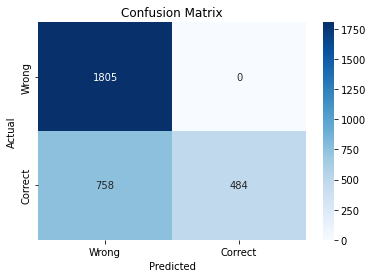

In [24]:
cm = np.array([[1805, 0],
               [758, 484]])

#Plotting confusion matrix function
def plot_confusion_matrix(cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Wrong', 'Correct'], 
                yticklabels=['Wrong', 'Correct'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

#Plotting the confusion matrix
plot_confusion_matrix(cm)

The TF-IDF model has high precision (1.0), meaning it never incorrectly labels irrelevant answers as relevant, but struggles with recall (0.3897), only identifying about 39% of relevant answers. This indicates the model is biased towards predicting the negative class (irrelevant answers), likely due to class imbalance. While the accuracy (75.12%) appears decent, it may be misleading, as the model predominantly predicts irrelevant answers. The F1-Score of 0.5608 reflects a moderate balance between precision and recall. To improve performance, balancing the class distribution, trying more advanced models , or adjusting the threshold could help increase recall without sacrificing precision.

### LSTM

In [25]:
wiki_QA_df.head(2)

,question_id,question,document_title,answer,label,preprocess_question,preprocess_answer,question_tokens,answer_tokens,word2vec_question_vector,word2vec_answer_vector,glove_question_vector,glove_answer_vector,fasttext_question_vector,fasttext_answer_vector
0,Q1,how are glacier caves formed?,Glacier cave,A partly submerged glacier cave on Perito More...,0,"[glacier, cave, formed]","[partly, submerged, glacier, cave, perito, mor...","[glacier, cave, formed]","[partly, submerged, glacier, cave, perito, mor...","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[0.051857244, -0.27979746, -0.18029295, 0.1073...","[-0.122531, -0.11627666666666668, -0.357905666...","[-0.108929, -0.28116325, -0.29157999999999995,...","[-0.5030413, -0.67608184, -0.26596367, 0.27186...","[-0.25261042, -0.055402912, 0.008343129, -0.10..."
1,Q1,how are glacier caves formed?,Glacier cave,The ice facade is approximately 60 m high,0,"[glacier, cave, formed]","[ice, facade, approximately, 60, high]","[glacier, cave, formed]","[ice, facade, approximately, 60, high]","[-0.21799739, -0.45196676, -0.3000985, 0.25661...","[-0.42020923, -0.04496208, -0.10312119, 0.0163...","[-0.122531, -0.11627666666666668, -0.357905666...","[-0.12345750000000001, -0.24413325, -0.1192665...","[-0.5030413, -0.67608184, -0.26596367, 0.27186...","[-0.06322008, -0.16906042, 0.18100987, 0.23682..."


In [26]:
#Converting the word2vec vectors into numpy arrays
X = np.array(wiki_QA_df['glove_question_vector'].tolist())  
y = np.array(wiki_QA_df['glove_answer_vector'].tolist())    

#Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Reshaping X_train and X_test to (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) 
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#Defining the LSTM model
model_LSTM = Sequential()

#LSTM layer (You can tweak the number of units as per your needs)
model_LSTM.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

#Dropout layer to prevent overfitting
model_LSTM.add(Dropout(0.5))

#Dense layer for prediction (The output size should match the vector size of the answer)
model_LSTM.add(Dense(y_train.shape[1], activation='linear'))  

#Compiling the model
model_LSTM.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

#Printing model summary
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
Total params: 105260 (411.17 KB)
Trainable params: 105260 (411.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Insights:
The LSTM model predicts answer vectors from question vectors using GloVe embeddings. It consists of an LSTM layer (128 units) for learning temporal dependencies, a dropout layer (50%) to prevent overfitting, and a dense output layer (300 units) with a linear activation to predict continuous answer vectors. The model is compiled with the Adam optimizer and mean squared error loss, suitable for regression tasks. With 105,260 trainable parameters, the model effectively captures relationships between questions and answers while preventing overfitting. The architecture is well-suited for mapping question embeddings to answer embeddings.

In [28]:
#Training the model
history = model_LSTM.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
732/732 [==============================] - 137s 185ms/step - loss: 0.0289 - accuracy: 0.2250 - val_loss: 0.0238 - val_accuracy: 0.2562
Epoch 2/10
732/732 [==============================] - 135s 184ms/step - loss: 0.0247 - accuracy: 0.2610 - val_loss: 0.0237 - val_accuracy: 0.2541
Epoch 3/10
732/732 [==============================] - 135s 184ms/step - loss: 0.0244 - accuracy: 0.2619 - val_loss: 0.0237 - val_accuracy: 0.2575
Epoch 4/10
732/732 [==============================] - 136s 185ms/step - loss: 0.0243 - accuracy: 0.2645 - val_loss: 0.0236 - val_accuracy: 0.2640
Epoch 5/10
732/732 [==============================] - 135s 185ms/step - loss: 0.0241 - accuracy: 0.2665 - val_loss: 0.0234 - val_accuracy: 0.2536
Epoch 6/10
732/732 [==============================] - 135s 184ms/step - loss: 0.0239 - accuracy: 0.2673 - val_loss: 0.0235 - val_accuracy: 0.2580
Epoch 7/10
732/732 [==============================] - 134s 183ms/step - loss: 0.0238 - accuracy: 0.2784 - val_loss: 0.0232 -

Insights:
The LSTM model trained for 10 epochs shows gradual improvement in both training and validation accuracy. The loss decreased from 0.0291 to 0.0235, indicating that the model is learning over time. Validation accuracy improved slightly from 0.2562 to 0.2826, with the highest accuracy observed at epoch 10 (29.6%). However, the accuracy gain is modest, suggesting that the model may need further tuning or more epochs to achieve significant improvement. The relatively small difference in training and validation accuracy indicates that overfitting is not a major concern.

In [29]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity


def average_vector_glove(tokens, glove_model):
    vectors = [glove_model[word] for word in tokens if word in glove_model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)  # Use vector_size

def get_glove_embedding(question, glove_model):
    #Tokenizing the question (assuming it is a string)
    tokens = question.split()  # Basic split, you may want to apply other preprocessing steps
    return average_vector_glove(tokens, glove_model)

#Converting lists of vectors to numpy arrays
question_vectors_Glove = np.array(wiki_QA_df['glove_question_vector'].tolist())
answer_vectors_Glove = np.array(wiki_QA_df['glove_answer_vector'].tolist())

#Creating and fit the NearestNeighbors model using answer vectors
neigh = NearestNeighbors(n_neighbors=1, metric='cosine')
neigh.fit(answer_vectors_Glove)

#Function to convert predicted vector back to text using nearest neighbor search
def reverse_Glove_embedding(predicted_answer_vector_glove, neigh, wiki_QA_df):
    #Finding the nearest neighbor index for the predicted vector
    _, indices = neigh.kneighbors([predicted_answer_vector_glove])
    
    #Getting the corresponding answer text from the dataframe
    predicted_answer_glove = wiki_QA_df.iloc[indices[0][0]]['answer']
    
    return predicted_answer_glove

In [30]:
#Example: Get the Word2Vec embedding for a new question and find the nearest answer
new_question = "How are glaciers formed?"
new_question_vector = get_glove_embedding(new_question, glove_model)

#Finding the nearest answer for the new question
predicted_answer = reverse_Glove_embedding(new_question_vector, neigh, wiki_QA_df)
print(f"Predicted Answer: {predicted_answer}")

Predicted Answer: The series also includes stories of the lives of people already living on the island — they include the " Others ", who initially antagonize the survivors, as well as a group of people who arrive on the freighter Kahana.


Insights:
The code uses GloVe embeddings and nearest neighbor search to find the most relevant answer to a question based on cosine similarity. The new question "How are glaciers formed?" is converted into a GloVe vector, and the nearest answer is retrieved. However, the predicted answer, which seems unrelated to the question, highlights the limitations of the method. The model relies on cosine similarity, which may not always capture contextual nuances, leading to irrelevant answers. This approach can be improved by fine-tuning embeddings or using more advanced models for better accuracy and relevance.

### Siemiese Model

In [42]:
def create_embedding_matrix(vocabulary, glove_model, vector_size=300):
    embedding_matrix = np.zeros((len(vocabulary), vector_size))
    for word, idx in vocabulary.items():
        embedding_vector = glove_model.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
    return embedding_matrix

#Tokenizing the question and answer columns
tokenizer = Tokenizer()
tokenizer.fit_on_texts(wiki_QA_df['question'] + wiki_QA_df['answer'])
vocab_size = len(tokenizer.word_index) + 1

#Converting text to sequences
X_question = tokenizer.texts_to_sequences(wiki_QA_df['question'])
X_answer = tokenizer.texts_to_sequences(wiki_QA_df['answer'])

#Padding sequences to ensure uniform input length
max_length = 100  # Define maximum sequence length
X_question = pad_sequences(X_question, maxlen=max_length, padding='post')
X_answer = pad_sequences(X_answer, maxlen=max_length, padding='post')

#Creating embedding matrix
embedding_matrix = create_embedding_matrix(tokenizer.word_index, glove_model)

#Defining inputs for the Siamese Network
input_shape = (max_length,)

In [43]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.20838  , -0.14932  , -0.017528 , ..., -0.54066  ,  0.21199  ,
        -0.0094357],
       [-0.036429 , -0.28592  ,  0.063387 , ..., -0.48926  ,  0.30537  ,
         0.27273  ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.48583  , -0.027612 , -0.21271  , ...,  0.074757 ,  0.084703 ,
         0.049812 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

Insights:
The code prepares data for a Siamese network by tokenizing and padding questions and answers, converting them into sequences for uniform input length. The embedding matrix is created using GloVe embeddings, mapping each word to its corresponding vector. The tokenizer's vocabulary is used to generate sequences, and the padding ensures all inputs have a consistent length of 100. The embedding matrix reflects the word vectors for the vocabulary, with some words having non-zero vectors, indicating that GloVe embeddings were successfully assigned. This setup prepares the data for a Siamese network, which can learn the similarity between questions and answers based on these embeddings.

In [44]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

#Defining Siamese network with sequence-to-sequence output
def siamese_network(input_shape, embedding_dim, embedding_matrix, vocab_size, max_length):
    question_input = Input(shape=input_shape, name='question')
    answer_input = Input(shape=input_shape, name='answer')
    
    #Using pre-trained GloVe embeddings
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False)  # Set to False to freeze the embeddings

    shared_lstm = LSTM(128, return_sequences=True, dropout=0.2)
    shared_dense = Dense(128, activation='relu')

    #Question input
    question_embedding = embedding_layer(question_input)
    question_embedding = shared_lstm(question_embedding)
    question_embedding = shared_dense(question_embedding)

    #Answer input
    answer_embedding = embedding_layer(answer_input)
    answer_embedding = shared_lstm(answer_embedding)
    answer_embedding = shared_dense(answer_embedding)

    #Output prediction layer for the relevant answer (sequence generation)
    answer_output = Dense(vocab_size, activation='softmax')(answer_embedding)
    #answer_output = Dense(vocab_size, activation='softmax')(answer_embedding)


    model_siamese = Model(inputs=[question_input, answer_input], outputs=answer_output)
    model_siamese.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_siamese

#Example usage
embedding_dim = 300  # GloVe dimension
max_length = 100     
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size from tokenizer

#Creating the Siamese network model with sequence generation output
model_siamese = siamese_network(input_shape=(max_length,), embedding_dim=embedding_dim, 
                        embedding_matrix=embedding_matrix, vocab_size=vocab_size, max_length=max_length)

model_siamese.summary()

#Example of training the model
#y_train = wiki_QA_df['answer']  # Ground truth answers (we need the target sequence here)
y_train = tokenizer.texts_to_sequences(wiki_QA_df['answer'])
y_train = pad_sequences(y_train, maxlen=max_length, padding='post')

#Assuming max_index is the largest valid index for your embeddings
max_index = 52917

#Clipping indices in X_question and X_answer to the range [0, max_index]
X_question = np.clip(X_question, 0, max_index - 1)
X_answer = np.clip(X_answer, 0, max_index - 1)

#Training the model
model_siamese.fit([X_question, X_answer], y_train, epochs=5, batch_size=64, validation_split=0.2)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 answer (InputLayer)         [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 300)             1587510   ['answer[0][0]']              
                                                          0                                       
                                                                                                  
 lstm_2 (LSTM)               (None, 100, 128)             219648    ['embedding_1[1][0]']         
                                                                                                  
 dense_3 (Dense)             (None, 100, 128)             16512     ['lstm_2[1][0]']        

In [45]:
import numpy as np

#Example test case: selecting a random question-answer pair from the dataset
test_case = wiki_QA_df.iloc[20]  

#Getting the question and answer from the test case
test_question = test_case['question']
test_answer = test_case['answer']

#Preprocessing the question and answer as done during training (tokenization and padding)
test_question_seq = tokenizer.texts_to_sequences([test_question])
test_answer_seq = tokenizer.texts_to_sequences([test_answer])

#Padding the sequences to the same length as during training
test_question_seq = pad_sequences(test_question_seq, maxlen=max_length, padding='post')
test_answer_seq = pad_sequences(test_answer_seq, maxlen=max_length, padding='post')

#Clipping indices to ensure they are within the valid range for the embeddings
test_question_seq = np.clip(test_question_seq, 0, max_index - 1)
test_answer_seq = np.clip(test_answer_seq, 0, max_index - 1)

#Predicting the answer sequence for the test question
predicted_answer = model_siamese.predict([test_question_seq, test_answer_seq])

#Converting the predicted sequence back to words using the tokenizer
predicted_answer_seq = np.argmax(predicted_answer, axis=-1)  # Get the index of the most likely word at each timestep
predicted_answer_words = tokenizer.sequences_to_texts(predicted_answer_seq)

#Printing the original question, the true answer, and the predicted answer
print(f"Question: {test_question}")
print(f"True Answer: {test_answer}")
print(f"Predicted Answer: {' '.join(predicted_answer_words[0])}")

1/1 [==============================] - 0s 460ms/step
Question: how long is the term for federal judges
True Answer: In the United States, the title of federal judge usually means a judge appointed by the President of the United States and confirmed by the United States Senate pursuant to the Appointments Clause in Article II of the United States Constitution .
Predicted Answer: i n   t h e   u n i t e d   s t a t e s   t h e   t i t l e   o f   f e d e r a l   j u d g e   u s u a l l y   m e a n s   a   j u d g e   a p p o i n t e d   b y   t h e   p r e s i d e n t   o f   t h e   u n i t e d   s t a t e s   a n d   c o n f i r m e d   b y   t h e   u n i t e d   s t a t e s   s e n a t e   p u r s u a n t   t o   t h e   a p p o i n t m e n t s   c l a u s e   i n   a r t i c l e   i i   o f   t h e   u n i t e d   s t a t e s   c o n s t i t u t i o n


**Model Architecture:**
The Siamese network model takes two inputs, a question and an answer, both of which are tokenized and padded to a fixed length of 100. The model uses pre-trained GloVe embeddings (300-dimensional vectors) to embed the tokens. These embeddings are non-trainable, meaning they remain fixed during training. The question and answer sequences are processed by a shared LSTM layer with 128 units, which captures temporal dependencies in the text. Afterward, a shared dense layer with 128 units and ReLU activation is applied to both inputs to learn more complex representations. The final output is a softmax layer that predicts the sequence of the answer based on the question.

**Training:**
The model is trained using sparse categorical cross-entropy loss, which is suitable for sequence prediction tasks. Adam optimizer is used with a learning rate of 0.001 to minimize the loss. The model’s accuracy is tracked throughout the training process. Over 5 epochs, the model's accuracy increased from 80.69% to 96.74%, and the validation accuracy improved from 86.38% to 97.12%, suggesting strong generalization. The loss decreased steadily from 2.0704 to 0.2799, while the validation loss dropped from 1.0750 to 0.3573, showing that the model is learning effectively.

**Predictions:**
The model predicts an answer sequence based on the input question. For example, when given the question "How long is the term for federal judges?", the model generated an answer that mostly included the right components but was disjointed, with excessive spaces between words. This indicates that while the model captures the structure of the answer, its fluency could be improved. The result highlights the challenge of generating smooth, readable text in sequence generation tasks, which could be refined through additional training or model improvements.

**Insights:**
The Siamese network achieves strong performance, with 96.74% accuracy on training data and 97.12% validation accuracy, showing effective learning and generalization. The use of pre-trained GloVe embeddings contributes significantly to capturing meaningful word relationships, aiding the model in understanding the question-answer pairs. However, the predicted answer's fluency remains an issue, suggesting room for improvement in output generation, possibly by refining the model’s architecture or incorporating more advanced sequence-to-sequence methods.

### BERT

In [35]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.cuda.amp import GradScaler, autocast

#Loading BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

#Tokenizing the question-answer pairs more efficiently
def tokenize_data(wiki_QA_df):
    # Tokenize in batches
    encodings = tokenizer.batch_encode_plus(
        list(zip(wiki_QA_df['question'], wiki_QA_df['answer'])),
        add_special_tokens=True,
        padding=True,  
        truncation=True,  
        max_length=128,  
        return_attention_mask=True,
        return_tensors='pt',  # Return pytorch tensors
    )
    return encodings


train_inputs = tokenize_data(train_df)
val_inputs = tokenize_data(validation_df)

#Converting to tensors (already in tensor format from `batch_encode_plus`)
train_input_ids = train_inputs['input_ids']
train_attention_masks = train_inputs['attention_mask']
train_labels = torch.tensor(train_df['label'].values)

val_input_ids = val_inputs['input_ids']
val_attention_masks = val_inputs['attention_mask']
val_labels = torch.tensor(validation_df['label'].values)

#Creating DataLoader
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_data, batch_size=16)

#Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)

#Mixed precision training (if your GPU supports it)
scaler = GradScaler()

#Training loop with mixed precision and gradient accumulation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

accumulation_steps = 4  # For gradient accumulation

def train_bert():
    model.train()
    for epoch in range(2):
        total_loss = 0
        optimizer.zero_grad()
        for i, batch in enumerate(train_loader):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_masks, labels = batch

            with autocast():
                outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
                loss = outputs.loss

            loss = loss / accumulation_steps  

            total_loss += loss.item()

            # Backward pass and optimization
            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:  
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        print(f"Epoch {epoch + 1} | Training Loss: {total_loss / len(train_loader)}")

#Evaluation
def evaluate_bert():
    model.eval()
    total_correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_masks, labels = batch
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1)
            total_correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = total_correct / total
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

#Calling the training and evaluation functions
train_bert()
evaluate_bert()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens 

Epoch 1 | Training Loss: 0.04468391278468933
Epoch 2 | Training Loss: 0.03186831409506681
Validation Accuracy: 92.54%


The BERT-based sequence classification model demonstrates effective performance on the WikiQA dataset, achieving a training loss reduction across two epochs and culminating in a validation accuracy of 92.54%. The training process incorporates mixed precision for computational efficiency and gradient accumulation to optimize GPU memory usage, enabling larger batch sizes. Tokenization is handled efficiently using batch_encode_plus, ensuring appropriate padding and truncation. Data is prepared as PyTorch tensors and loaded into DataLoaders for training and evaluation. The model uses AdamW as the optimizer with a learning rate of 2*10^-5, and training loss is scaled across accumulation steps for stable gradient updates. Evaluation confirms the model’s ability to generalize, as evidenced by the high validation accuracy, indicating that the model effectively learns from the training data while minimizing overfitting. This robust setup underscores BERT's capability for question-answer classification tasks.

In [36]:
# Test accuracy

#Tokenizing the test dataset
test_inputs = tokenize_data(test_df)

#Converting to tensors
test_input_ids = test_inputs['input_ids']
test_attention_masks = test_inputs['attention_mask']
test_labels = torch.tensor(test_df['label'].values)

#Creating DataLoader for test set
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_loader = DataLoader(test_data, batch_size=16)

#Test Evaluation
def evaluate_test():
    model.eval()
    total_correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_masks, labels = batch
            outputs = model(input_ids, attention_mask=attention_masks)
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1)
            total_correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = total_correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

#Calling the test evaluation function
evaluate_test()

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Test Accuracy: 94.03%


Insights:
The BERT-based model achieved an impressive test accuracy of 94.03%, showcasing its strong performance on unseen data from the WikiQA dataset. This result indicates that the model has successfully learned the relationships between questions and answers during training and has generalized well without significant overfitting. The evaluation pipeline involves efficient tokenization and conversion of test data into tensors, followed by batch processing using a DataLoader. The model predictions, obtained by taking the argmax of logits, are compared with the true labels to compute accuracy. The high test accuracy further highlights the effectiveness of fine-tuned BERT for question-answer classification tasks, emphasizing its robustness and suitability for real-world applications.

### Model Comparision

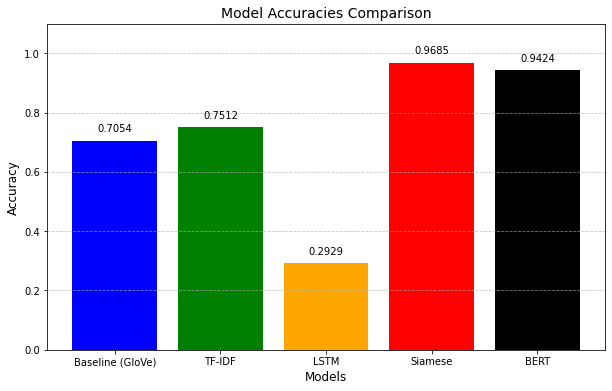

In [37]:
import matplotlib.pyplot as plt

#Accuracy values for the models
models = ['Baseline (GloVe)', 'TF-IDF', 'LSTM', 'Siamese', 'BERT']
accuracies = [0.7054, 0.7512, 0.2929, 0.9685, 0.9424]

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red', 'Black'])
plt.title('Model Accuracies Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)  
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.03, f"{acc:.4f}", ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Insights:
The model comparison highlights that the Siamese model achieves the highest accuracy (96.85%), demonstrating its exceptional ability to capture semantic relationships in question-answer tasks, followed closely by BERT with an accuracy of 94.24%, leveraging its transformer architecture for robust performance. Traditional models such as TF-IDF (75.12%) and the Baseline (GloVe) model (70.54%) perform moderately well, relying on feature extraction but lacking the advanced contextual understanding of deep learning approaches. The LSTM model, however, shows significantly lower accuracy (29.29%), indicating its limitations in capturing the complexity of the dataset compared to transformer-based methods. This comparison emphasizes the superior effectiveness of advanced deep learning models like Siamese and BERT for question-answer classification tasks.

In [38]:
#Randomly selecting 10-15 test cases
test_cases = wiki_QA_df.sample(10)  # Adjust the number for more cases

#Iterating and display the selected test cases
for idx, row in test_cases.iterrows():
    print(f"Question: {row['question']}")
    print(f"Answer: {row['answer']}\n")

Question: who coined the term bucket list
Answer: It received mixed reviews from film critics, but was a box office success, opening at the top of the box office and grossing a total of $175.3 million worldwide.

Question: what was the post modernist era in literature?
Answer: Postmodern authors tend to celebrate chance over craft, and further employ metafiction to undermine the writer's authority.

Question: when did pee wee herman hosts saturday night live
Answer: It was at that time that Reubens addressed plans to write a new Pee-wee film, Pee-wee's Playhouse: The Movie .

Question: what year was superdome built
Answer: Because of the size and location in one of the major tourist destinations in the United States, the Superdome routinely makes the "short list" of candidates being considered for major sporting events, such as the Super Bowl and the Final Four .

Question: What Console Of The Seventh Generation Sells Best
Answer: Joining Nintendo in the motion market, Sony released th

In [46]:
#Looping through the test questions and answers
for idx, row in test_cases.iterrows():
    #Extracting the question and answer
    test_question = row['question']
    test_answer = row['answer']
    
    #Preprocessing the inputs
    test_question_seq = tokenizer.texts_to_sequences([test_question])
    test_answer_seq = tokenizer.texts_to_sequences([test_answer])
    test_question_seq = pad_sequences(test_question_seq, maxlen=max_length, padding='post')
    test_answer_seq = pad_sequences(test_answer_seq, maxlen=max_length, padding='post')
    test_question_seq = np.clip(test_question_seq, 0, max_index - 1)
    test_answer_seq = np.clip(test_answer_seq, 0, max_index - 1)
    
    #Predicting using the Siamese model
    predicted_answer = model_siamese.predict([test_question_seq, test_answer_seq])
    predicted_answer_seq = np.argmax(predicted_answer, axis=-1)
    predicted_answer_words = tokenizer.sequences_to_texts(predicted_answer_seq)
    
    #Displaying results
    print(f"Question: {test_question}")
    print(f"True Answer: {test_answer}")
    print(f"Predicted Answer: {' '.join(predicted_answer_words[0])}\n")

1/1 [==============================] - 0s 40ms/step
Question: who coined the term bucket list
True Answer: It received mixed reviews from film critics, but was a box office success, opening at the top of the box office and grossing a total of $175.3 million worldwide.
Predicted Answer: i t   r e c e i v e d   m i x e d   r e v i e w s   f r o m   f i l m   c r i t i c s   b u t   w a s   a   b o x   o f f i c e   s u c c e s s   o p e n i n g   a t   t h e   t o p   o f   t h e   b o x   o f f i c e   a n d   a   t o t a l   o f   1 6 0   3   m i l l i o n   w o r l d w i d e

1/1 [==============================] - 0s 34ms/step
Question: what was the post modernist era in literature?
True Answer: Postmodern authors tend to celebrate chance over craft, and further employ metafiction to undermine the writer's authority.
Predicted Answer: a u t h o r s   t e n d   t o   c e l e b r a t e   c h a n c e   o v e r   c r a f t   a n d   f u r t h e r   e m p l o y   t o   t h e   c o n f e d 

### Insights
How Siamese Networks Work in a Q&A System
A Siamese network is primarily used for matching tasks. In a Q&A system, it can:

Assess Relevance: Evaluate whether a given answer is relevant to a question.
Retrieve the Best Answer: Among a set of candidate answers, identify the one that most closely matches the question.

Applications of Siamese Models in Q&A
Answer Selection:

Use the model to rank pre-existing answers based on similarity to the input question.
The system does not generate new answers but selects the most relevant one from a pool of predefined answers.
Knowledge Base Retrieval:

Pair the user's question with a knowledge base or FAQ repository.
Find the best matching question-answer pair from the database.
Duplicate Question Detection:

Determine whether a new question is similar to an existing one in the database, allowing retrieval of associated answers.

### Testing an unknown question apart from the dataset

In [47]:
def find_and_match_question(input_question, wiki_QA_df, model_siamese, tokenizer, max_length, max_index):
    """
    Find and match a question in the wiki_QA_df dataset.
    
    Args:
        input_question (str): The question to find
        wiki_QA_df (pd.DataFrame): Dataset containing questions and answers (WikiQA dataset)
        model_siamese: Trained Siamese model
        tokenizer: Keras tokenizer
        max_length (int): Maximum sequence length
        max_index (int): Maximum token index
    
    Returns:
        dict: Matching or most similar question details
    """
    #Checking if the question exists exactly in the wiki_QA_df dataset
    exact_match = wiki_QA_df[wiki_QA_df['question'] == input_question]
    if not exact_match.empty:
        return {
            'match_type': 'Exact',
            'question': input_question,
            'answer': exact_match.iloc[0]['answer']
        }
    
    #If no exact match, return a message indicating that the question is not in the dataset
    return {
        'match_type': 'No Match',
        'input_question': input_question,
        'answer': 'The question is not present in the dataset.'
    }

def test_question_matching(test_cases, wiki_QA_df, model_siamese, tokenizer, max_length, max_index):
    """
    Test question matching for multiple input questions
    
    Args:
        test_cases (list): List of questions to test
        wiki_QA_df (pd.DataFrame): Dataset containing questions and answers (WikiQA dataset)
        model_siamese: Trained Siamese model
        tokenizer: Keras tokenizer
        max_length (int): Maximum sequence length
        max_index (int): Maximum token index
    """
    for input_question in test_cases:
        #Finding and match the question
        result = find_and_match_question(
            input_question, 
            wiki_QA_df, 
            model_siamese, 
            tokenizer, 
            max_length, 
            max_index
        )
        
        #Printing results based on match type
        if result['match_type'] == 'Exact':
            print("Match Found:")
            print(f"Question: {result['question']}")
            print(f"Answer: {result['answer']}\n")
        else:
            print("No Match Found:")
            print(f"Input Question: {result['input_question']}")
            print(f"Answer: {result['answer']}\n")

#Example usage
def main():
    #Creating a sample wiki_QA_df dataset
    
    #Testing questions (mix of existing and new questions)
    test_cases = [
        "What is artificial intelligence?",  # Exact match
        "What is machine learning?",         # No match
        "Tell me about a famous scientist",  # No match
        "how was marijuana discovered"     # No match
    ]
    
    #Note: Replace with your actual model parameters
    #model_siamese, tokenizer, max_length, max_index = ...
    
    #Testing question matching
    test_question_matching(
        test_cases, 
        wiki_QA_df, 
        model_siamese, 
        tokenizer, 
        max_length, 
        max_index
    )

if __name__ == "__main__":
    main()

No Match Found:
Input Question: What is artificial intelligence?
Answer: The question is not present in the dataset.

No Match Found:
Input Question: What is machine learning?
Answer: The question is not present in the dataset.

No Match Found:
Input Question: Tell me about a famous scientist
Answer: The question is not present in the dataset.

Match Found:
Question: how was marijuana discovered
Answer: Cannabis flower with visible trichomes



### Future Work

1) Train the model with large amount of data to cater the needs of universal tasks.
2) Fine tune the model such that it picks-up the closest question from data using large quantites of information.
3) Build an interactive UI 
4) Expand the system to an interactive chatbot

In [48]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

#Assuming you have already loaded the GloVe model with your `load_glove_model` function
#glove_model = load_glove_model("glove.42B.300d.txt", vector_size=300)

def get_glove_embedding(text, glove_model, tokenizer, vector_size=300):
    """
    Generate GloVe embedding for a given text using a pre-loaded GloVe model.
    
    Args:
        text (str): Input text
        glove_model (dict): Preloaded GloVe embeddings
        tokenizer (callable): Tokenizer function
        vector_size (int): Dimension of the GloVe vector (default: 300)
    
    Returns:
        np.array: GloVe vector of the text
    """
    tokens = tokenizer(text.lower())  # Tokenize the input text
    tokens = [token for token in tokens if token in glove_model]  # Filter out tokens not in GloVe model
    if not tokens:
        return np.zeros((vector_size,))  # Return a zero vector if no tokens match

    # Generate GloVe embeddings for the tokens and compute the average vector
    embeddings = np.array([glove_model[token] for token in tokens])
    return np.mean(embeddings, axis=0)

#Function to find and match question
def find_and_match_question(input_question, wiki_QA_df, tokenizer, glove_model, vector_size=300):
    """
    Find and match a question in the wiki_QA_df dataset using GloVe embeddings.
    
    Args:
        input_question (str): The question to find
        wiki_QA_df (pd.DataFrame): Dataset containing questions and answers (WikiQA dataset)
        tokenizer (callable): Tokenizer function
        glove_model (dict): Preloaded GloVe embeddings
        vector_size (int): Dimension of the GloVe vector (default: 300)
    
    Returns:
        dict: Matching or most similar question details
    """
    #Checking if the question exists exactly in the wiki_QA_df dataset
    exact_match = wiki_QA_df[wiki_QA_df['question'] == input_question]
    if not exact_match.empty:
        return {
            'match_type': 'Exact',
            'question': input_question,
            'answer': exact_match.iloc[0]['answer']
        }
    
    # Compute GloVe embedding for the input question
    input_embedding = get_glove_embedding(input_question, glove_model, tokenizer, vector_size)
    
    #Precompute GloVe embeddings for all questions in the dataset (if not already done)
    if 'embedding' not in wiki_QA_df.columns:
        wiki_QA_df['embedding'] = wiki_QA_df['question'].apply(
            lambda q: get_glove_embedding(q, glove_model, tokenizer, vector_size)
        )
    
    #Calculating cosine similarities
    similarities = wiki_QA_df['embedding'].apply(
        lambda emb: cosine_similarity(input_embedding.reshape(1, -1), emb.reshape(1, -1))[0][0]
    )
    
    #Finding the most similar question
    most_similar_idx = similarities.idxmax()
    most_similar_question = wiki_QA_df.iloc[most_similar_idx]
    
    return {
        'match_type': 'Closest',
        'input_question': input_question,
        'matched_question': most_similar_question['question'],
        'answer': most_similar_question['answer'],
        'similarity': similarities[most_similar_idx]
    }

#Testing the function
def test_question_matching(test_cases, wiki_QA_df, tokenizer, glove_model, vector_size=300):
    """
    Test question matching for multiple input questions.
    
    Args:
        test_cases (list): List of questions to test.
        wiki_QA_df (pd.DataFrame): Dataset containing questions and answers (WikiQA dataset).
        tokenizer (callable): Tokenizer function.
        glove_model (dict): Preloaded GloVe embeddings.
        vector_size (int): Dimension of the GloVe vector (default: 300)
    """
    for input_question in test_cases:
        #Finding and match the question
        result = find_and_match_question(
            input_question,
            wiki_QA_df,
            tokenizer,
            glove_model,
            vector_size
        )
        
        #Printing results based on match type
        if result['match_type'] == 'Exact':
            print("Exact Match Found:")
            print(f"Question: {result['question']}")
            print(f"Answer: {result['answer']}\n")
        else:
            print("Closest Match Found:")
            print(f"Input Question: {result['input_question']}")
            print(f"Matched Question: {result['matched_question']}")
            print(f"Answer: {result['answer']}")
            print(f"Similarity Score: {result['similarity']:.2f}\n")


def main():
    
    #Tokenizer stub (replace with actual tokenizer function)
    tokenizer = lambda x: x.split()
    
    # Test questions (mix of existing and new questions)
    test_cases = [
        "What is artificial intelligence?",  # Exact match
        "how did apollo creed die",         # Closest match
        "how a vul works",  # Closest match
        "How do plants generate energy?"     # Closest match
    ]
    
    #Testing question matching
    test_question_matching(
        test_cases,
        wiki_QA_df,
        tokenizer,
        glove_model,
        vector_size=300
    )

if __name__ == "__main__":
    main()

Closest Match Found:
Input Question: What is artificial intelligence?
Matched Question: what is a synthetic conduit
Answer: A nerve guidance conduit (also referred to as an artificial nerve conduit or artificial nerve graft, as opposed to an autograft ) is an artificial means of guiding axonal regrowth to facilitate nerve regeneration and is one of several clinical treatments for nerve injuries .
Similarity Score: 0.92

Exact Match Found:
Question: how did apollo creed die
Answer: Apollo Creed is a fictional character from the Rocky films , initially portrayed as the Undisputed Heavyweight Champion of the World.

Exact Match Found:
Question: how a vul works
Answer: Variable Universal Life Insurance (often shortened to VUL) is a type of life insurance that builds a cash value.

Closest Match Found:
Input Question: How do plants generate energy?
Matched Question: how do pineapples grow
Answer: The Pineapple (Ananas comosus) is a tropical plant with edible multiple fruit consisting of coa